### Задание
Попробуйте поэкспериментировать со следующими параметрами нейронной сети:<br> 
<br> 
* Для полносвязной сети:<br>
    * кол-во слоев нейронной сети <br> 
    * кол-во нейронов в каждом слое <br>
    * функции активации на промежуточных слоях <br> 
<br>
* Для сверточной сети:<br>
    * кол-во фильтров в сверточном слое <br>
    * размер фильтра в сверточном слое <br>
    * размер окна в пулинг слое. <br>
<br>
1.  Обучите нейронную сеть (полносвязную и сверточную) пробуя разные комбинации перечисленных выше параметров, <br> 
2. Составьте таблицу с зависимость точности нейронной сети на обучающих и тестовых данных, от значения параметра, <br>
3. Напишите Ваши выводы о том, как тот или иной параметр влияет на точность обучения нейронной сети.

### Import & Util functions

#### Import

In [23]:
from genericpath import exists

import numpy as np                  
import matplotlib.pyplot as plt      
import random                        

from keras.datasets import mnist     # MNIST dataset 
from keras.models import Sequential  # Model Нейронной сети

from keras.layers.core import Dense, Dropout, Activation # Функции Активации и Слои нейронной сети
from keras.utils import np_utils 

from keras.models import load_model

#### Вспомогательная функция для расчета и вывода метрик

In [3]:
import sklearn
from sklearn import metrics
def calcMetrics(y_predict, y_true):
    return [metrics.accuracy_score(y_true, y_predict),
            metrics.precision_score(y_true, y_predict, average='weighted', zero_division=0),
            metrics.recall_score(y_true, y_predict, average='weighted', zero_division=0),
            metrics.f1_score(y_true, y_predict, average='weighted', zero_division=0)]
def printMetrics(m):
    print(f"Accuracy = {m[0]}, Precision = {m[1]}, Recall = {m[2]}, F1 = {m[3]}")

#### Вспомогательная функция для вывода таблицы по классам и корреляционной матрицы

In [4]:
import matplotlib
import pandas as pd
from matplotlib.pyplot import title, xlabel, ylabel
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

dfMetricsCols = ['Accuracy', 'Precision', 'Recall', 'F1']
dfConfCols = ['True Positive', 'True Negative', 'False Positive']
def setDfRow(dfMetrics, dfConf, i, cmat, y_predict, y_true):
    i_cmat = i - 1
    dfMetrics.iloc[i][0], dfMetrics.iloc[i][1], dfMetrics.iloc[i][2], dfMetrics.iloc[i][3] =  calcMetrics(y_predict, y_true)

    if i == 0: # для строки Total
        dfConf.iloc[i][0] = np.sum(cmat.diagonal())
        dfConf.iloc[i][1] = np.sum(np.ravel(cmat)) - np.sum(np.ravel(cmat.diagonal())) - np.sum(np.ravel(np.tril(cmat, -1)))
        dfConf.iloc[i][2] = np.sum(np.ravel(np.tril(cmat, -1)))
    else: # для строк с конкретными буквами
        dfConf.iloc[i][0] = cmat[i_cmat][i_cmat]
        dfConf.iloc[i][1] = np.sum(cmat[i_cmat]) - cmat[i_cmat][i_cmat]
        dfConf.iloc[i][2] = np.sum(cmat[i_cmat]) - cmat[i_cmat][i_cmat]

def plotCorr(fig, ax, y_predict, y_true):
    cmat = confusion_matrix(y_true, y_predict)
    class_dict = [chr(i) for i in range(48, 48+10)]

    plot_confusion_matrix(
        conf_mat=cmat,
        class_names=class_dict,
        colorbar=True,
        figure=fig,
        axis=ax
    )
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')

    indexDf = np.array(['Total'])
    indexDf = np.append(indexDf, class_dict)
    dfConf = pd.DataFrame(index=indexDf, columns=dfConfCols)
    dfMetrics = pd.DataFrame(index=indexDf, columns=dfMetricsCols)

    setDfRow(dfMetrics, dfConf, 0, cmat, y_predict, y_true) # row for total val

    for i_val, c in enumerate(class_dict):
        i = i_val + 1
        classIndexes = np.where(y_true == i_val)
        y_class = y_predict[classIndexes]
        y_check = y_true[classIndexes]
        
        setDfRow(dfMetrics, dfConf, i, cmat, y_class, y_check)

    return dfMetrics, dfConf

#### Вспомогательная функция для именования save/load файлов

In [ ]:
def getModelPathById(id, sType):
    return f"model_{sType}.{id}"

### Скачиваем датасет

In [5]:
#  60,000 28 x 28 pixel тренировочные изображения и  10,000 28 x 28 pixel тестовые изображения
(X_train_original, y_train_original), (X_test_original, y_test_original) = mnist.load_data()

print("X_train shape", X_train_original.shape)
print("y_train shape", y_train_original.shape)
print("X_test shape", X_test_original.shape)
print("y_test shape", y_test_original.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


#### Выводим пример данных

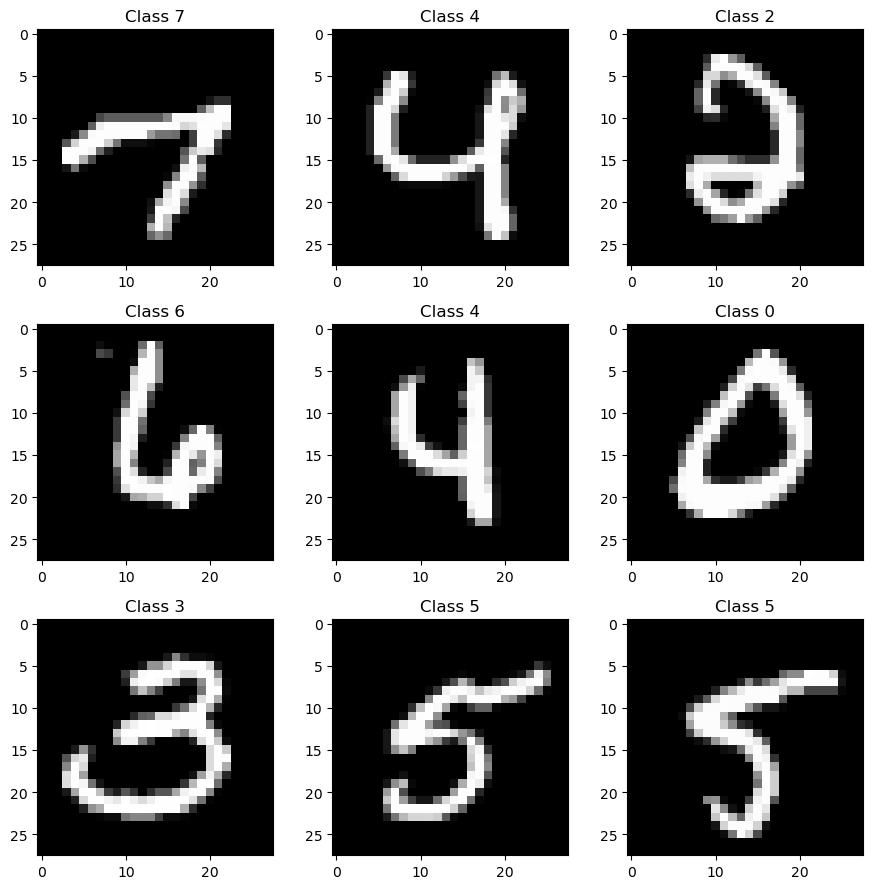

In [6]:
plt.rcParams['figure.figsize'] = (9,9) 

for i in range(9):
    plt.subplot(3, 3, i+1)
    num = random.randint(0, len(X_train_original))

    plt.imshow(X_train_original[num], cmap='gray', interpolation='none')
    plt.title(f"Class {y_train_original[num]}")
    
plt.tight_layout()

### Модель полносвязной нейронной сети

#### Подготовка данных для НН

In [7]:
# вытягиваем в вектора
X_train = X_train_original.reshape(60000, 784) 
X_test = X_test_original.reshape(10000, 784)   

# конертируем в float
X_train = X_train.astype('float32')   
X_test = X_test.astype('float32')

X_train /= 255                       
X_test /= 255

In [8]:
# one-hot формат
nb_classes = 10 # Кол-во классов (всего 10 цифр)

Y_train = np_utils.to_categorical(y_train_original, nb_classes)
Y_test = np_utils.to_categorical(y_test_original, nb_classes)

#### Модель

In [9]:
def createFCN(nLayer = 2, nNeuron = 512, sActivationFn = 'relu'):
    model_FCN = Sequential()

    for layer in range(nLayer):
        model_FCN.add(Dense(nNeuron, input_shape=(784 if layer == 0 else nNeuron,))) 
        model_FCN.add(Activation(sActivationFn))
        model_FCN.add(Dropout(0.2)) # Dropout - это аналог регуляризации в нейронных сетях

    # Последний уровень FCN должен быть равен количеству желаемых классов (в данном случае 10).
    model_FCN.add(Dense(10))
    model_FCN.add(Activation('softmax'))

    # /* Сборка модели */ 
    # Keras построен на основе Theano и TensorFlow. Оба пакета позволяют вам определять граф вычислений в Python,
    # который затем компилируется и эффективно запускается на CPU или GPU без дополнительных затрат на интерпретатор Python.
    #
    # При составлении модели Keras просит вас указать вашу функцию потерь и ваш оптимизатор. 
    # Функция потерь, которую мы здесь будем использовать, называется категориальной кросс-энтропией и является функцией потерь, 
    # хорошо подходящей для сравнения двух распределений вероятностей.
    #
    # Оптимизатор помогает определить, насколько быстро модель обучается с помощью градиентного спуска. 
    # Скорость, с которой сходится градиент, называется скоростью обучения.
    model_FCN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model_FCN

#### Варьирование параметров

In [18]:
params_FCN = {
    "nLayer" : range(1, 5),
    "nNeuron" : [32, 64, 128, 256, 512, 1024],
    "sActivationFn" : ["relu", "sigmoid", "tanh"]
}

#### Обучение

batch_size определяет, сколько данных на шаг используется для вычисления функции потерь, градиентов и обратного распространения. Большие размеры пакетов позволяют сети быстрее завершить обучение; Однако следует учитывать и другие факторы, помимо скорости тренировки.

Слишком большой размер batch_size пакета сглаживает локальные минимумы функции потерь, в результате чего оптимизатор застревает в Локальном минимуме.
Слишком маленький размер batch_siz пакета создает очень "зашумленную" функцию потерь, и оптимизатор может никогда не найти глобальный минимум.

epochs - количество итераций над каждым примером
verbose - вывод текстового прогресс бара 

In [21]:
iModel = 0

for nLayer in params_FCN['nLayer']:
    print(f"========= nLayer = {nLayer} =========")
    for nNeuron in params_FCN['nNeuron']:
        print(f"======  nNeuron = {nNeuron} ======")
        for sActivationFn in params_FCN['sActivationFn']:
            print(f"===  sActivationFn = {sActivationFn} ===")
            currentPath = getModelPathById(iModel, "FCN")
            if not exists(currentPath):
                model_FCN = createFCN(nLayer, nNeuron, sActivationFn)
                model_FCN.fit(X_train, Y_train,
                        batch_size=32, epochs=10,
                        verbose=1)
                        
                model_FCN.save(currentPath)
                del model_FCN

            iModel += 1

========= nLayer = 1 =========
======  nNeuron = 32 ======
===  sActivationFn = relu ===
Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4823 - accuracy: 0.8576
Epoch 2/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2884 - accuracy: 0.9148
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2490 - accuracy: 0.9251
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2271 - accuracy: 0.9312
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2134 - accuracy: 0.9347
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2026 - accuracy: 0.9373
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1920 - accuracy: 0.9414
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1871 - accuracy: 0.9415
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1818 - accuracy:

#### Таблица accuracy

In [60]:
iModel = 0

def getModelAccuracyStr(model):
    predictTrain = model.predict(X_train, verbose=0)
    predictTrain = np.argmax(predictTrain, axis=1)
    predictTest = model.predict(X_test, verbose=0)
    predictTest = np.argmax(predictTest, axis=1)
    train_accuracy = metrics.accuracy_score(y_train_original, predictTrain)
    test_accuracy = metrics.accuracy_score(y_test_original, predictTest)
    return ["{:.3f}".format(train_accuracy), "{:.3f}".format(test_accuracy)]

print("Точность на обучающей/тестовой выборке\n")
for sActivationFn in params_FCN['sActivationFn']:
    print(f"sActivationFn = {sActivationFn}")
    columns = ["Кол-во слоёв"]
    columns.extend(f"Кол-во нейронов {x}" for x in params_FCN["nNeuron"])
    accuracy_table = pd.DataFrame(columns=columns)

    for iLayer, nLayer in enumerate(params_FCN['nLayer']):
        accuracy_row = [str(nLayer)]
        for nNeuron in params_FCN['nNeuron']:
            model = load_model(getModelPathById(iModel, "FCN"))
            accTrain, accTest = getModelAccuracyStr(model) 
            accuracy_row.append(str(f"{accTrain} / {accTest}"))
            iModel += 1
        accuracy_table.loc[nLayer] = accuracy_row
    display(accuracy_table)

Точность на обучающей/тестовой выборке

sActivationFn = relu


,Кол-во слоёв,Кол-во нейронов 32,Кол-во нейронов 64,Кол-во нейронов 128,Кол-во нейронов 256,Кол-во нейронов 512,Кол-во нейронов 1024
1,1,0.972 / 0.963,0.965 / 0.953,0.968 / 0.958,0.989 / 0.975,0.980 / 0.970,0.983 / 0.969
2,2,0.994 / 0.978,0.989 / 0.977,0.991 / 0.976,0.997 / 0.983,0.994 / 0.980,0.995 / 0.978
3,3,0.996 / 0.981,0.996 / 0.983,0.994 / 0.978,0.997 / 0.981,0.998 / 0.983,0.995 / 0.980
4,4,0.971 / 0.961,0.959 / 0.954,0.969 / 0.959,0.987 / 0.973,0.979 / 0.969,0.983 / 0.972


sActivationFn = sigmoid


,Кол-во слоёв,Кол-во нейронов 32,Кол-во нейронов 64,Кол-во нейронов 128,Кол-во нейронов 256,Кол-во нейронов 512,Кол-во нейронов 1024
1,1,0.994 / 0.978,0.990 / 0.978,0.989 / 0.975,0.991 / 0.979,0.995 / 0.982,0.994 / 0.978
2,2,0.996 / 0.982,0.997 / 0.981,0.993 / 0.978,0.994 / 0.981,0.996 / 0.982,0.986 / 0.974
3,3,0.968 / 0.960,0.958 / 0.952,0.965 / 0.956,0.985 / 0.974,0.977 / 0.963,0.981 / 0.970
4,4,0.992 / 0.979,0.989 / 0.978,0.988 / 0.973,0.993 / 0.980,0.994 / 0.981,0.992 / 0.978


sActivationFn = tanh


,Кол-во слоёв,Кол-во нейронов 32,Кол-во нейронов 64,Кол-во нейронов 128,Кол-во нейронов 256,Кол-во нейронов 512,Кол-во нейронов 1024
1,1,0.993 / 0.979,0.994 / 0.981,0.989 / 0.976,0.992 / 0.980,0.996 / 0.983,0.982 / 0.973
2,2,0.969 / 0.960,0.947 / 0.939,0.965 / 0.955,0.983 / 0.973,0.974 / 0.963,0.979 / 0.968
3,3,0.990 / 0.979,0.987 / 0.974,0.988 / 0.976,0.992 / 0.981,0.992 / 0.978,0.987 / 0.973
4,4,0.993 / 0.980,0.993 / 0.979,0.986 / 0.976,0.992 / 0.980,0.994 / 0.979,0.974 / 0.966


#### Выводы

### Модель сверточной нейронной сети

#### Подготовка данных для НН

In [ ]:
X_train_conv = X_train_original.reshape(60000, 28, 28, 1) 
X_test_conv = X_test_original.reshape(10000, 28, 28, 1)

X_train_conv = X_train_conv.astype('float32')         
X_test_conv = X_test_conv.astype('float32')

X_train_conv /= 255                              
X_test_conv /= 255

print("Training matrix shape", X_train_conv.shape)
print("Testing matrix shape", X_test_conv.shape)

In [ ]:
# import 
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization.batch_normalization import BatchNormalization

#### Модель

In [ ]:
def createCN(nFilter, nKernal, nPool, nLayer, nNeuron, sActivationFn):
    model_conv = Sequential()                                 
    kernalSize = (nKernal, nKernal)
    poolSize = (nPool, nPool)

    # Сверточный слой 1
    model_conv.add(Conv2D(nFilter, kernalSize, input_shape=(28,28,1)))
    model_conv.add(BatchNormalization(axis=-1))                
    model_conv.add(Activation('relu'))

    # Сверточный слой 2
    model_conv.add(Conv2D(nFilter, kernalSize))                        
    model_conv.add(BatchNormalization(axis=-1))               
    model_conv.add(Activation('relu'))                        
    model_conv.add(MaxPooling2D(pool_size=poolSize)) # MaxPool операция 2x2 kernel

    # Сверточный слой 3
    model_conv.add(Conv2D(2 * nFilter, kernalSize))                         # 64 РАЗНЫХ! 3x3 kernels -- so 64 feature maps
    model_conv.add(BatchNormalization(axis=-1))              
    model_conv.add(Activation('relu'))

    # Сверточный слой 4
    model_conv.add(Conv2D(2 * nFilter, kernalSize))                        
    model_conv.add(BatchNormalization(axis=-1))               
    model_conv.add(Activation('relu'))                        # activation
    model_conv.add(MaxPooling2D(pool_size=poolSize)) # MaxPool операция 2x2 kernel
    model_conv.add(Flatten())                                 # Разворачиваем матрицу 4x4x64 в 1024-мерный плоский вектор

    # Полносвязные слои
    for layer in range(nLayer):
        model_conv.add(Dense(nNeuron))
        model_conv.add(BatchNormalization(axis=-1))                
        model_conv.add(Activation(sActivationFn))
        model_conv.add(Dropout(0.2)) # Dropout - это аналог регуляризации в нейронных сетях

    # Последний уровень FCN должен быть равен количеству желаемых классов (в данном случае 10).
    model_conv.add(Dense(10))
    model_conv.add(Activation('softmax'))
    model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Варьирование параметров

In [ ]:
params_CN = {
    # Параметры свёрточных слоёв
    "nFilter" : [16, 32, 64],
    "nKernalAndPool" : [(2,2), (2,3), (2,4), (3,2), (3,3), (4,2)],

    # Параметры полносвязных слоёв
    "nLayer" : range(1, 5),
    "nNeuron" : [32, 64, 128, 256, 512, 1024],
    "sActivationFn" : ["relu", "sigmoid", "tanh"]
}

#### Обучение

In [ ]:
iModel = 0

for nLayer in params_FCN['nLayer']:
    print(f"========= nLayer = {nLayer} =========")
    for nNeuron in params_FCN['nNeuron']:
        print(f"======  nNeuron = {nNeuron} ======")
        for sActivationFn in params_FCN['sActivationFn']:
            print(f"===  sActivationFn = {sActivationFn} ===")
            currentPath = getModelPathById(iModel, "CN")
            if not exists(currentPath):
                model_FCN = createFCN(nLayer, nNeuron, sActivationFn)
                model_FCN.fit(X_train, Y_train,
                        batch_size=32, epochs=10,
                        verbose=1)
                        
                model_FCN.save(currentPath)
                del model_FCN

            iModel += 1

#### Предикт

In [ ]:
y_test_predicted = model_conv.predict(X_test_conv)
y_test_predicted_c = np.argmax(y_test_predicted, axis=1)

#### Метрики валидационного набора

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
df1 ,df2 = plotCorr(fig, ax, y_test_predicted_c, y_test_original)
df1.join(df2)